# Duygu Analizi Modeli Eğitimi

Bu notebook'ta FER2013 veri setini kullanarak duygu tanıma modelimizi eğiteceğiz.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

# Duygu sınıfları
EMOTIONS = ['Kizgin', 'Igrenme', 'Korku', 'Mutlu', 'Uzgun', 'Saskin', 'Notr']

cwd = os.getcwd()
print("Geçerli çalışma dizini:", cwd)



Geçerli çalışma dizini: C:\Users\ymete\Desktop\Kodlarim\bitirme1\notebooks


## Veri Setinin Hazırlanması

FER2013 veri setini yükleyip ön işleme yapacağız.


In [4]:
def load_images_from_directory(directory):
    images = []
    labels = []
    emotion_map = {
        'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3,
        'sad': 4, 'surprise': 5, 'neutral': 6
    }
    
    for emotion in emotion_map.keys():
        path = os.path.join(directory, emotion)
        if os.path.exists(path):
            for img_file in os.listdir(path):
                if img_file.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(path, img_file)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, (48, 48))
                        img = img.astype('float32') / 255.0
                        images.append(img)
                        label = [0] * len(emotion_map)
                        label[emotion_map[emotion]] = 1
                        labels.append(label)
    
    return np.array(images), np.array(labels)

# Eğitim ve test verilerini yükle
print("Eğitim verilerini yüklüyorum...")
x_train, y_train = load_images_from_directory('../data/raw/train')

print("Test verilerini yüklüyorum...")
x_test, y_test = load_images_from_directory('../data/raw/test')

# Görüntüleri doğru formata dönüştür
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(f"Eğitim seti boyutu: {x_train.shape}")
print(f"Test seti boyutu: {x_test.shape}")


Eğitim verilerini yüklüyorum...
Test verilerini yüklüyorum...
Eğitim seti boyutu: (28709, 48, 48, 1)
Test seti boyutu: (7178, 48, 48, 1)


In [5]:
def create_model(input_shape=(48, 48, 1), num_classes=7):
    inputs = Input(shape=input_shape)
    
    # İlk konvolüsyon bloğu
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # İkinci konvolüsyon bloğu
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Üçüncü konvolüsyon bloğu
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Dördüncü konvolüsyon bloğu
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Global Average Pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Yoğun katmanlar
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Model oluştur
model = create_model()

# Model özetini göster
model.summary()

# Modeli derle
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Modeli oluştur ve derle
model = create_model()
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model özetini göster
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,704,711 (33.21 MB)

 Trainable params: 8,696,263 (33.17 MB)

 Non-trainable params: 8,448 (33.00 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,704,711 (33.21 MB)

 Trainable params: 8,696,263 (33.17 MB)

 Non-trainable params: 8,448 (33.00 KB)

## Model Mimarisi

CNN tabanlı bir model oluşturacağız.


In [7]:
def create_model(input_shape=(48, 48, 1), num_classes=7):
    model = Sequential([
        Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

model = create_model()
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


C:\Users\ymete\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


C:\Users\ymete\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Model eğitimi başlıyor...
Epoch 1/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.2039 - loss: 2.3177

898/898 ━━━━━━━━━━━━━━━━━━━━ 298s 327ms/step - accuracy: 0.2039 - loss: 2.3175 - val_accuracy: 0.1239 - val_loss: 31.6774 - learning_rate: 0.0010
Epoch 2/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.2273 - loss: 1.9847

898/898 ━━━━━━━━━━━━━━━━━━━━ 293s 327ms/step - accuracy: 0.2273 - loss: 1.9847 - val_accuracy: 0.1303 - val_loss: 11.4448 - learning_rate: 0.0010
Epoch 3/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.2361 - loss: 1.9167

898/898 ━━━━━━━━━━━━━━━━━━━━ 310s 345ms/step - accuracy: 0.2361 - loss: 1.9167 - val_accuracy: 0.2471 - val_loss: 4.4812 - learning_rate: 0.0010
Epoch 4/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 284s 316ms/step - accuracy: 0.2366 - loss: 1.8963 - val_accuracy: 0.2385 - val_loss: 1.9916 - learning_rate: 0.0010
Epoch 5/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 274s 305ms/step - accuracy: 0.2455 - loss: 1.8816 - val_accuracy: 0.1588 - val_loss: 1.9220 - learning_rate: 0.0010
Epoch 6/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 273s 304ms/step - accuracy: 0.2403 - loss: 1.8661 - val_accuracy: 0.1330 - val_loss: 6.2156 - learning_rate: 0.0010
Epoch 7/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 342s 381ms/step - accuracy: 0.2443 - loss: 1.8548 - val_accuracy: 0.1638 - val_loss: 3.5726 - learning_rate: 0.0010
Epoch 8/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 338s 376ms/step - accuracy: 0.2399 - loss: 1.8421 - val_accuracy: 0.1353 - val_loss: 9.3654 - learning_rate: 0.0010
Epoch 9/100
898/898 ━━━━━━━━━━━━━━━━━━━━ 348s 387ms/step - accuracy: 0

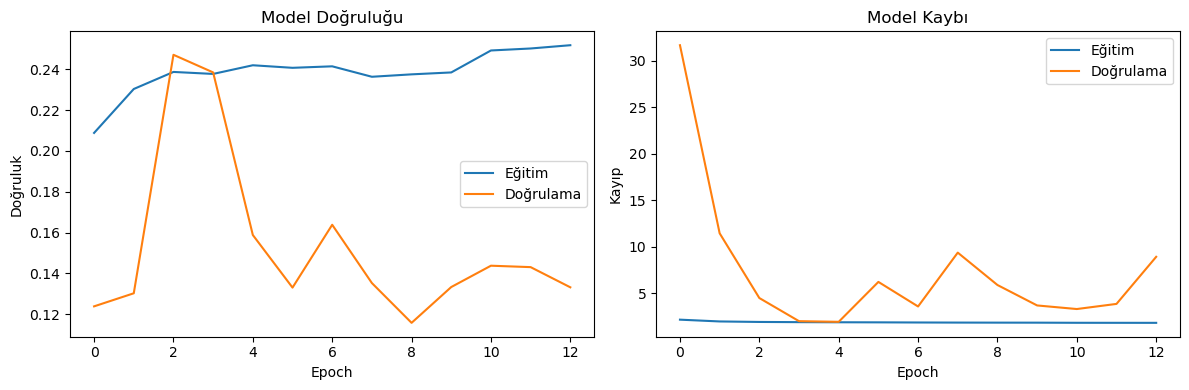


Test seti üzerinde değerlendirme:
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.2217 - loss: 5.1939
Test doğruluğu: 0.2471
Test kaybı: 4.4812
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step


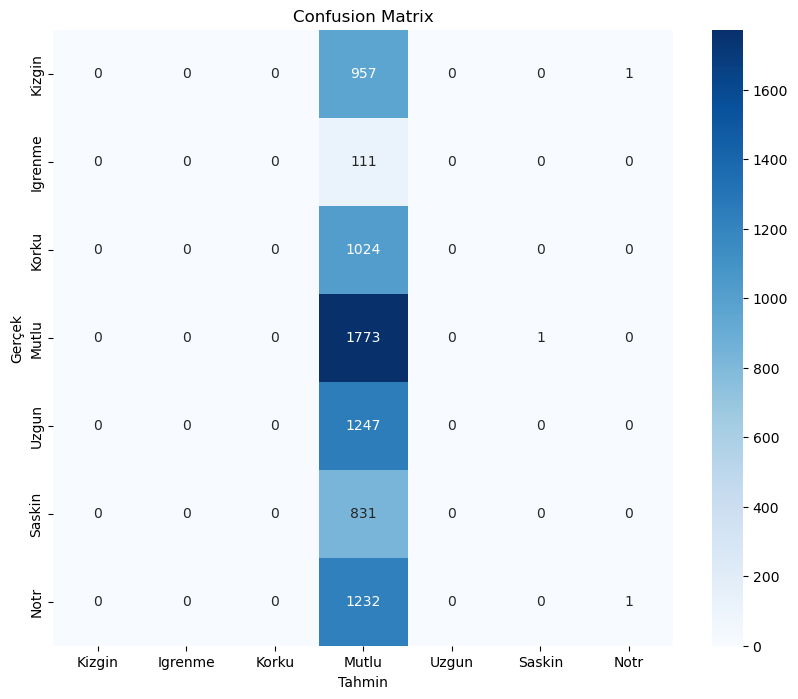

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Sınıf bazında performans metrikleri:
              precision    recall  f1-score   support

      Kizgin       0.00      0.00      0.00       958
     Igrenme       0.00      0.00      0.00       111
       Korku       0.00      0.00      0.00      1024
       Mutlu       0.25      1.00      0.40      1774
       Uzgun       0.00      0.00      0.00      1247
      Saskin       0.00      0.00      0.00       831
        Notr       0.50      0.00      0.00      1233

    accuracy                           0.25      7178
   macro avg       0.11      0.14      0.06      7178
weighted avg       0.15      0.25      0.10      7178


Model kaydedildi: ../data/models/emotion_model.h5


In [8]:
# Veri artırma için ImageDataGenerator ayarları
train_datagen = ImageDataGenerator(
    rotation_range=20,           # Rastgele döndürme
    width_shift_range=0.2,       # Yatay kaydırma
    height_shift_range=0.2,      # Dikey kaydırma
    zoom_range=0.2,              # Yakınlaştırma/uzaklaştırma
    horizontal_flip=True,        # Yatay çevirme
    brightness_range=[0.8,1.2],  # Parlaklık ayarı
    fill_mode='nearest'          # Boşlukları doldurma yöntemi
)

# Test verisi için sadece normalizasyon
test_datagen = ImageDataGenerator()

# Eğitim parametreleri
EPOCHS = 100
BATCH_SIZE = 32
EARLY_STOPPING_PATIENCE = 10

# Early stopping ve model checkpoint için callback'ler
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=EARLY_STOPPING_PATIENCE,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='../data/models/emotion_model_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7
    )
]

# Model eğitimi
print("Model eğitimi başlıyor...")
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(x_test, y_test),
    epochs=EPOCHS,
    callbacks=callbacks
)

# Eğitim sonuçlarını görselleştir
plt.figure(figsize=(12, 4))

# Doğruluk grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim')
plt.plot(history.history['val_accuracy'], label='Doğrulama')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

# Kayıp grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim')
plt.plot(history.history['val_loss'], label='Doğrulama')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.tight_layout()
plt.show()

# En iyi modeli değerlendir
print("\nTest seti üzerinde değerlendirme:")
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test doğruluğu: {test_accuracy:.4f}")
print(f"Test kaybı: {test_loss:.4f}")

# Confusion matrix oluştur
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=EMOTIONS,
            yticklabels=EMOTIONS)
plt.title('Confusion Matrix')
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.show()

# Sınıf bazında metrikler
print("\nSınıf bazında performans metrikleri:")
classification_report_str = classification_report(
    y_true_classes, 
    y_pred_classes, 
    target_names=EMOTIONS
)
print(classification_report_str)

# Modeli kaydet
model.save('../data/models/emotion_model.h5')
print("\nModel kaydedildi: ../data/models/emotion_model.h5")


In [9]:
# Veri artırma
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Model eğitimi
batch_size = 64
epochs = 50

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_test, y_test),
    epochs=epochs,
    steps_per_epoch=len(x_train) // batch_size
)


Epoch 1/50


C:\Users\ymete\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 295s 659ms/step - accuracy: 0.2201 - loss: 1.8847 - val_accuracy: 0.2767 - val_loss: 1.7706
Epoch 2/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:05 682ms/step - accuracy: 0.2656 - loss: 1.8401

C:\Users\ymete\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


448/448 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.2656 - loss: 1.8401 - val_accuracy: 0.2768 - val_loss: 1.7678
Epoch 3/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 308s 687ms/step - accuracy: 0.2751 - loss: 1.7843 - val_accuracy: 0.3352 - val_loss: 1.7023
Epoch 4/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.3438 - loss: 1.7810 - val_accuracy: 0.3296 - val_loss: 1.7306
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 292s 651ms/step - accuracy: 0.3488 - loss: 1.6362 - val_accuracy: 0.4182 - val_loss: 1.4947
Epoch 6/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.3125 - loss: 1.6472 - val_accuracy: 0.4221 - val_loss: 1.4820
Epoch 7/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 311s 693ms/step - accuracy: 0.4286 - loss: 1.4716 - val_accuracy: 0.4968 - val_loss: 1.2996
Epoch 8/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.4219 - loss: 1.2980 - val_accuracy: 0.4972 - val_loss: 1.2983
Epoch 9/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 315s 703ms/step - accuracy: 0.4698 - loss: 1.3811 - val

In [10]:
## Eğitim Sonuçlarının Görselleştirilmesi


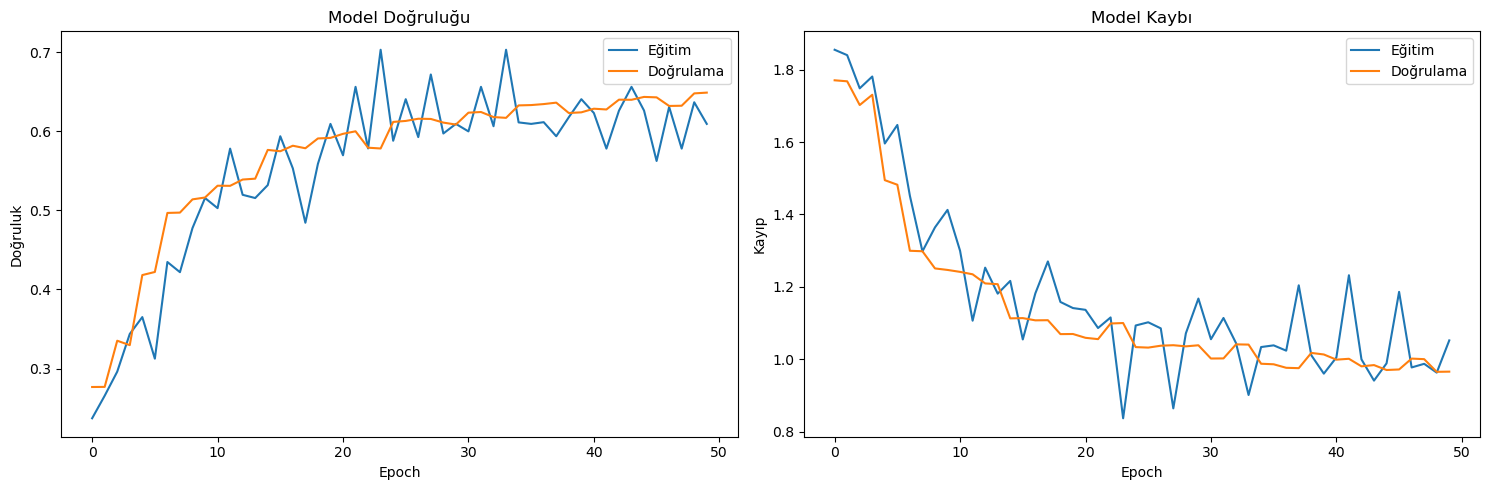

In [11]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Doğruluk grafiği
    ax1.plot(history.history['accuracy'], label='Eğitim')
    ax1.plot(history.history['val_accuracy'], label='Doğrulama')
    ax1.set_title('Model Doğruluğu')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Doğruluk')
    ax1.legend()
    
    # Kayıp grafiği
    ax2.plot(history.history['loss'], label='Eğitim')
    ax2.plot(history.history['val_loss'], label='Doğrulama')
    ax2.set_title('Model Kaybı')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Kayıp')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [12]:
## Modeli Kaydet


In [13]:
# Modeli kaydet
model.save('../data/models/emotion_model.h5')
print("Model başarıyla kaydedildi!")


Model başarıyla kaydedildi!
